In [1]:
import torch
import torchvision
import matplotlib as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

batch_size = 64
num_epochs = 40

correctant = 0

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])
    
train_set = torchvision.datasets.ImageFolder('./../melanoma_cancer_dataset/train', transform = transform)
test_set = torchvision.datasets.ImageFolder('./../melanoma_cancer_dataset/test', transform = transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

In [2]:
from torchvision.models import mobilenet_v2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = mobilenet_v2(pretrained = False, num_classes=2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)


cuda:0


C:\Users\Marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   

        # forward pass
        output = model(inputs.float())
        #loss = criterion(output, target.unsqueeze(1).float())
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.cpu().numpy()) 
           
    return losses

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
    global correctant
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            output = model(inputs.float())
            # apply softmax to convert output to probabilities
            output = torch.softmax(output, dim=1)
            # get the predicted class by selecting the class with the highest probability
            _, pred = torch.max(output, 1)
            
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.tolist())

            if correctant < accuracy_score(y_true, y_pred):
                torch.save(model.state_dict(), "mobilenet_v2_state_dict.pth")
                correctant = accuracy_score(y_true, y_pred)
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Training loss = 0.073538 test accuracy = 0.900000: 100%|██████████| 40/40 [27:38<00:00, 41.47s/it]


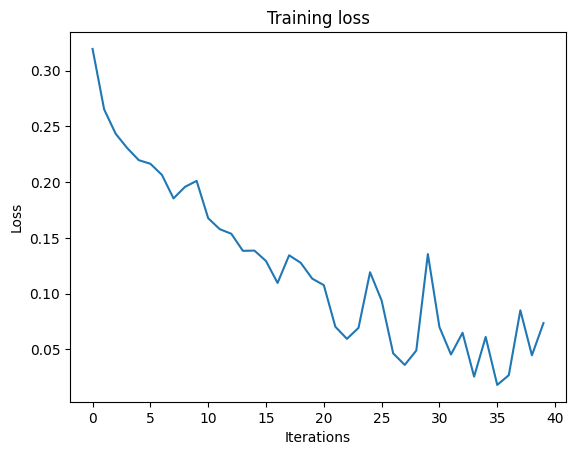

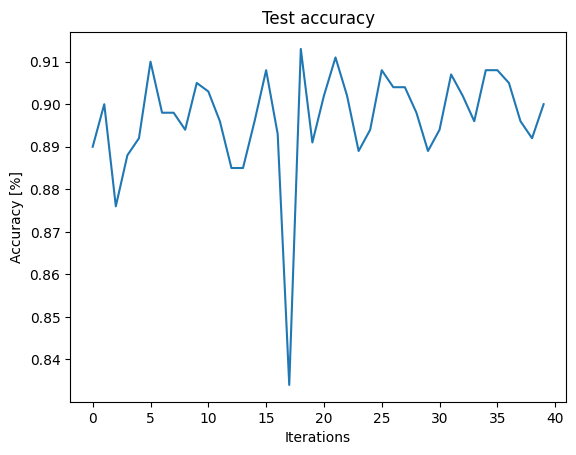

0.9

In [4]:
from tqdm import tqdm, trange
import numpy as np

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, train_loader, optimizer, criterion)
        test_acc = test(model, test_loader)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

test(model, test_loader)

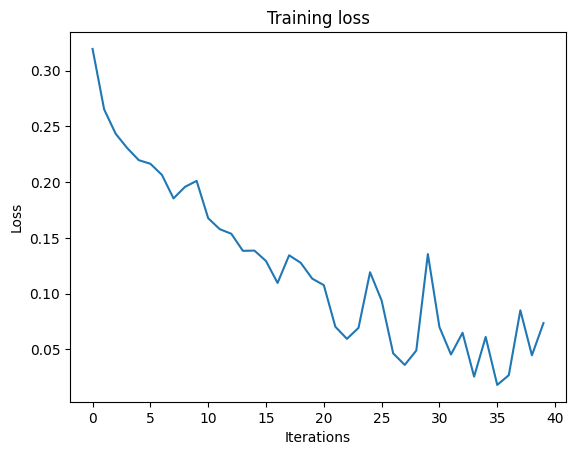

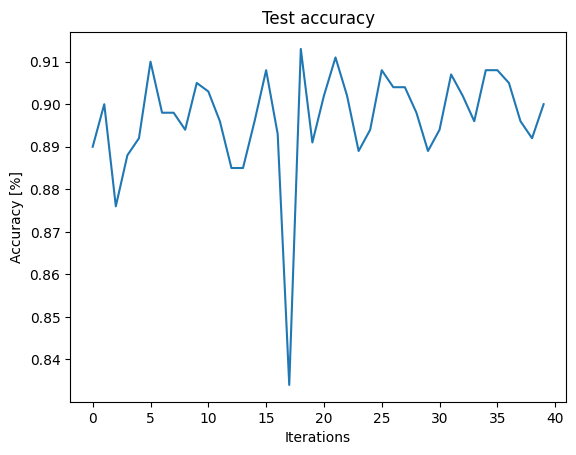

0.9

In [5]:
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

test(model, test_loader)